In [1]:
import sys
sys.path.append('../03-code/')
from config import PROJECT_ROOT_DIRECTORY, COLUMNS_DICT
import pandas as pd

In [2]:
organic_genome_dataframe = pd.read_csv(
    PROJECT_ROOT_DIRECTORY + '02-metadata/06-csv-files/01-organic-genome.csv', index_col='identifier'
)
organic_genome_dataframe

,smiles_canonical,generation
identifier,,
1,[NH3+]Cc1cc2sc(C[NH3+])cc2s1,2.0
2,[NH3+]Cc1cc2sc([NH3+])cc2s1,3.0
3,[NH3+]c1cc2sc([NH3+])cc2s1,4.0
4,[NH3+]Cc1ccc(C[NH3+])s1,1.0
5,[NH3+]Cc1ccc(C[NH3+])o1,2.0
...,...,...
40605,[NH3+]Cc1ccc2nc(-c3cs[nH+]n3)[nH]c2c1,6.0
40606,[NH3+]Cc1ccc2nc(-c3cn[nH+]s3)[nH]c2c1,6.0
40607,Cc1c[nH+]nc2oc(C[NH3+])nc12,6.0


In [12]:
# read the energy level alignment data and formability decision data iteratively from generation 0 to 4
forward_design_dataframe = pd.DataFrame()
for i in range(0,7):
    fingerprint_csv = PROJECT_ROOT_DIRECTORY + '01-rawdata/01-molecular-generation/fingerprints/fingerprints_generation_' + str(i) + '.csv'
    fingerprint_dataframe = pd.read_csv(fingerprint_csv)

    mo_prediction_csv = PROJECT_ROOT_DIRECTORY + '01-rawdata/01-molecular-generation/mo-prediction/mo_prediction_generation_' + str(i) + '.csv'
    energy_level_alignment_dataframe = pd.read_csv(mo_prediction_csv)

    formability_score_csv = PROJECT_ROOT_DIRECTORY + '01-rawdata/12-formability-score/formability_score_generation_' + str(i) + '.csv'
    formability_score_dataframe = pd.read_csv(formability_score_csv)[['smiles_canonical', 'formability_score']]
    formability_score_dataframe['formability_decision'] = formability_score_dataframe['formability_score'].apply(lambda x: True if x > 0.85 else False)

    pubchem_existence_csv = PROJECT_ROOT_DIRECTORY + '01-rawdata/15-pubchem-existence/existence_generation_' + str(i) + '.csv'   
    pubchem_existence_dataframe = pd.read_csv(pubchem_existence_csv)[['smiles_canonical', 'cid']]
    pubchem_existence_dataframe['PubChem_existence'] = pubchem_existence_dataframe['cid'].notna()

    combined_dataframe = pd.merge(energy_level_alignment_dataframe, formability_score_dataframe, on='smiles_canonical', how='left')
    combined_dataframe = pd.merge(combined_dataframe, fingerprint_dataframe, on='smiles_canonical', how='left')
    combined_dataframe = pd.merge(combined_dataframe, pubchem_existence_dataframe, on='smiles_canonical', how='left')
    combined_dataframe['synthesizability_decision'] = combined_dataframe['PubChem_existence'] & combined_dataframe['formability_decision']
    combined_dataframe['generation'] = i
    forward_design_dataframe = pd.concat([forward_design_dataframe, combined_dataframe], axis=0, ignore_index=True)

In [16]:
forward_design_dataframe.to_csv(PROJECT_ROOT_DIRECTORY+'02-metadata/06-csv-files/13-forward-design.csv', index=False)

In [5]:
forward_design_dataframe = pd.read_csv(PROJECT_ROOT_DIRECTORY+'02-metadata/06-csv-files/13-forward-design.csv')

In [14]:
import plotly.graph_objects as go

# Define colors for different types
node_colors = {
    'Ia': 'rgb(31, 119, 180)',  # Blue
    'Ib': 'rgb(44, 160, 44)',  # Green
    'IIa': 'rgb(255, 127, 14)',  # Orange
    'IIb': 'rgb(214, 39, 40)'   # Red
}

link_color_transparent = 'rgba(169,169,169,0.2)'  # Light gray transparent for "not" condition
default_link_color = 'rgba(0,0,0,0.4)'  # Default link color (black, semi-transparent)

def get_sankey_data(df, columns):

    boolean_columns = {
        'PubChem_existence': ['yes', 'no'],
        'formability_decision': ['yes', 'no'],
        'synthesizability_decision': ['yes', 'no']
    }
    df = df.copy()
    for column, (yes_label, no_label) in boolean_columns.items():
        df[column] = df.apply(lambda row: f"{row['alignment_type_prediction']}_{yes_label}" if row[column] 
                              else f"{row['alignment_type_prediction']}_{no_label}", axis=1)
    df = df[columns]

    # step 1: Create unique nodes for each column value
    node_counts = {}  # Dictionary to store the count of samples per node
    #all_nodes = {f"{col}_{val}" for col in columns for val in df[col].unique()}
    #all_nodes_sorted = sorted(all_nodes)
    all_nodes_sorted = ['generation_6','generation_5','generation_4', 'generation_3', 'generation_2', 'generation_1', 'generation_0',
                        'alignment_type_prediction_Ia', 'alignment_type_prediction_Ib','alignment_type_prediction_IIa', 'alignment_type_prediction_IIb', 
                        'PubChem_existence_Ia_yes','PubChem_existence_Ia_no', 'PubChem_existence_Ib_yes', 'PubChem_existence_Ib_no','PubChem_existence_IIa_yes', 'PubChem_existence_IIa_no', 'PubChem_existence_IIb_yes',  'PubChem_existence_IIb_no', 
                        'formability_decision_Ia_yes', 'formability_decision_Ia_no',  'formability_decision_Ib_yes', 'formability_decision_Ib_no', 'formability_decision_IIa_yes','formability_decision_IIa_no', 'formability_decision_IIb_yes','formability_decision_IIb_no', 
                        'synthesizability_decision_Ia_yes','synthesizability_decision_Ia_no',  'synthesizability_decision_Ib_yes',  'synthesizability_decision_Ib_no','synthesizability_decision_IIa_yes' ,'synthesizability_decision_IIa_no',  'synthesizability_decision_IIb_yes', 'synthesizability_decision_IIb_no',
]
    
    node_map = {node: i for i, node in enumerate(all_nodes_sorted)}

    # Count the number of occurrences for each node
    for col in columns:
        col_counts = df[col].value_counts()
        for val, count in col_counts.items():
            node_counts[f"{col}_{val}"] = count

    # Step 2: Create an empty list to store sources, targets, and values (flows)
    sources, targets, values = [], [], []
    link_colors, node_colors_list = [], []
    node_customdata = []
    
    # Loop through the columns and create flows from column to column
    for i in range(len(columns) - 1):
        source_column = columns[i]
        target_column = columns[i + 1]
        
        # Group by source and target values, count the number of flows
        flow_data = df.groupby([source_column, target_column]).size().reset_index(name='counts')
        
        # Append the source, target, and flow values to the respective lists
        for _, row in flow_data.iterrows():
            source = f"{source_column}_{row[source_column]}"
            target = f"{target_column}_{row[target_column]}"
            count = row['counts']
            
            sources.append(node_map[source])
            targets.append(node_map[target])
            values.append(count)

            if 'no' in target or 'no' in source:
                link_colors.append(link_color_transparent)  # Make transparent if target contains "not"
            else:
                link_colors.append(default_link_color)  # Default color otherwise

    # Step 4: Assign colors to nodes based on node names (Ia, IIa, Ib, IIb)
    for node in all_nodes_sorted:
        if '_Ia' in node:
            node_colors_list.append(node_colors['Ia'])
        elif '_IIa' in node:
            node_colors_list.append(node_colors['IIa'])
        elif '_Ib' in node:
            node_colors_list.append(node_colors['Ib'])
        elif '_IIb' in node:
            node_colors_list.append(node_colors['IIb'])
        else:
            node_colors_list.append('rgba(128,128,128,0.8)')  # Default gray color for unspecified nodes

        # Add the count of samples for this node to custom data for hover
        node_customdata.append(node_counts.get(node, 0))

    link_data = pd.DataFrame(
        {
            'sources': sources,
            'targets': targets,
            'values': values,
            'link_colors': link_colors
        }
    )
    node_data = pd.DataFrame(
        {
            'label': list(node_map.keys()),
            'node_colors': node_colors_list,
            'node_customdata': node_customdata
        }
    )

    return link_data, node_data

descriptor_columns = ['generation','alignment_type_prediction', 'PubChem_existence', 'formability_decision', 'synthesizability_decision']
link_data, node_data = get_sankey_data(forward_design_dataframe, descriptor_columns)


In [18]:
# save the parameters to a csv file
link_data.to_csv(PROJECT_ROOT_DIRECTORY + '01-rawdata/14-forward-design-candidates/sankey/links-data.csv', index=False)
node_data.to_csv(PROJECT_ROOT_DIRECTORY + '01-rawdata/14-forward-design-candidates/sankey/nodes-data.csv', index=False)

In [5]:
# read the data back from the csv files
link_data = pd.read_csv(PROJECT_ROOT_DIRECTORY + '01-rawdata/14-forward-design-candidates/sankey/links-data.csv')
node_data = pd.read_csv(PROJECT_ROOT_DIRECTORY + '01-rawdata/14-forward-design-candidates/sankey/nodes-data.csv')

In [15]:
# Create the Sankey diagram using Plotly
fig = go.Figure(go.Sankey(
    arrangement="perpendicular",
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=node_data['label'],  # Labels for the nodes
        x=[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.25,0.25,0.25,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.75,0.75,0.75,0.75,0.75,0.75,0.75,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0],
        y=[0.05,0.15,0.2,0.3,0.4,0.5,0.7,0.1,0.25,0.6,0.9,0.05,0.12,0.22,0.28,0.35,0.6,0.85,0.9,0.1,0.18,0.25,0.3,0.58,0.85,0.9,0.05,0.13,0.22,0.28,0.35,0.6,0.85,0.9],
        color=node_data['node_colors'],  # Colors for the nodes
        customdata=node_data['node_customdata'],  # Custom data for hover (number of samples)
        hovertemplate='Node: %{label}<br>Samples: %{customdata}<extra></extra>',  # Custom hover text
    ),
    link=dict(
        source=link_data['sources'],  # List of sources (node indices)
        target=link_data['targets'],  # List of targets (node indices)
        value=link_data['values'],     # List of flow values
        color=link_data['link_colors']
    ),
))
fig

In [ ]:
# save the figure
fig.write_image('../rawfigures/sankey-plot.svg')

In [ ]:
dataframe_Ib = dataframe.query('synthesizability_decision == True and alignment_type_prediction == "Ib"')
dataframe_Ib.to_csv(PROJECT_ROOT_DIRECTORY+'01-rawdata/14-forward-design-candidates/forward-design-type-Ib.csv', index=False)

In [ ]:
dataframe_IIb = dataframe.query('synthesizability_decision == True and alignment_type_prediction == "IIb"')
dataframe_IIb.to_csv(PROJECT_ROOT_DIRECTORY+'01-rawdata/14-forward-design-candidates/forward-design-type-IIb.csv', index=False)

In [3]:
type_Ib_dataframe = pd.read_csv(
    PROJECT_ROOT_DIRECTORY + '01-rawdata/14-forward-design-candidates/forward-design-type-Ib.csv'
)
type_IIa_dataframe = pd.read_csv(
    PROJECT_ROOT_DIRECTORY + '01-rawdata/14-forward-design-candidates/forward-design-type-IIa.csv'
)
type_IIb_dataframe = pd.read_csv(
    PROJECT_ROOT_DIRECTORY + '01-rawdata/14-forward-design-candidates/forward-design-type-IIb.csv'
)
forward_design_dataframe = pd.concat(
    [type_Ib_dataframe, type_IIa_dataframe, type_IIb_dataframe], axis=0, ignore_index=True
)
forward_design_dataframe

,smiles_canonical,HOMO_prediction,LUMO_prediction,alignment_type_prediction,STEI_score,eccentricity_score,linker_position_score,NumRot_tail_score,disNN_score,formability_score,...,pyrrole,sidechain_on_linker,sidechain_on_backbone,smiles_neutral,iupac_name,cid,generation,PubChem_existence,formability_decision,synthesizability_decision
0,[NH3+]c1ccc2cc(-c3ccc4cc([NH3+])ccc4c3)ccc2c1,-10.901790,-7.408124,Ib,1.000000,1.000000,1.000000,0.926551,0.999969,0.985304,...,0,0,0,Nc1ccc2cc(-c3ccc4cc(N)ccc4c3)ccc2c1,NaN,140160832.0,5,True,True,True
1,[NH3+]c1ccc(-c2ccc3c(ccc4cc([NH3+])ccc43)c2)cc1,-10.901790,-7.408124,Ib,1.000000,1.000000,1.000000,0.926551,0.999969,0.985304,...,0,0,0,Nc1ccc(-c2ccc3c(ccc4cc(N)ccc43)c2)cc1,NaN,169911042.0,5,True,True,True
2,[NH3+]Cc1ccc2c(c1)sc1cc3c(cc12)sc1cc([NH3+])ccc13,-9.253438,-6.690609,Ib,1.000000,1.000000,1.000000,0.999455,0.999969,0.999885,...,0,0,0,NCc1ccc2c(c1)sc1cc3c(cc12)sc1cc(N)ccc13,NaN,129262180.0,5,True,True,True
3,[NH3+]Cc1ccc2c(c1)sc1c2ccc2c3ccc([NH3+])cc3sc21,-9.253438,-6.690609,Ib,1.000000,1.000000,1.000000,0.999455,0.999964,0.999884,...,0,0,0,NCc1ccc2c(c1)sc1c2ccc2c3ccc(N)cc3sc21,NaN,126613993.0,5,True,True,True
4,[NH3+]Cc1ccc2c(c1)sc1c2sc2c3ccc([NH3+])cc3sc21,-9.259019,-6.711807,Ib,1.000000,1.000000,1.000000,0.999455,0.999964,0.999884,...,0,0,0,NCc1ccc2c(c1)sc1c2sc2c3ccc(N)cc3sc21,NaN,126493586.0,5,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,[NH3+]Cc1ccc2nc(-c3cn[nH+]s3)[nH]c2c1,-13.135643,-9.615489,IIb,0.925875,1.000000,1.000000,0.926551,0.999932,0.970471,...,1,0,0,NCc1ccc2nc(-c3cnns3)[nH]c2c1,NaN,136279877.0,6,True,True,True
148,Cc1c[nH+]nc2oc(C[NH3+])nc12,-14.920516,-10.765456,IIb,0.418435,0.999999,1.000000,0.926551,0.999560,0.868909,...,0,0,1,Cc1cnnc2oc(CN)nc12,NaN,82414954.0,6,True,True,True
149,Cc1c[nH+]nc2sc(C(C)[NH3+])nc12,-14.840007,-10.650242,IIb,0.358494,0.999999,1.000000,0.926551,0.999560,0.856921,...,0,1,1,Cc1cnnc2sc(C(C)N)nc12,NaN,82400975.0,6,True,True,True
150,[NH3+]CCc1nnc[nH+]n1,-16.335366,-11.268060,IIb,0.942571,0.999680,0.999779,0.999455,0.998078,0.987913,...,0,0,0,NCCc1nncnn1,NaN,22639488.0,6,True,True,True


In [38]:
# append the smiles_canonical in forward_design_dataframe not in organic_genome_dataframe to the end of organic_genome_dataframe
forward_design_dataframe_n = forward_design_dataframe[~forward_design_dataframe['smiles_canonical'].isin(organic_genome_dataframe['smiles_canonical'])]
forward_design_dataframe_n


,smiles_canonical,HOMO_prediction,LUMO_prediction,alignment_type_prediction,STEI_score,eccentricity_score,linker_position_score,NumRot_tail_score,disNN_score,formability_score,...,pyrrole,sidechain_on_linker,sidechain_on_backbone,smiles_neutral,iupac_name,cid,generation,PubChem_existence,formability_decision,synthesizability_decision
8,[NH3+]Cc1ccc2nc3c(ccc4cc5cc(C[NH3+])ccc5nc43)c...,-9.325391,-6.903762,Ib,1.000000,1.000000,1.000000,0.999996,0.999974,0.999994,...,0,0,0,NCc1ccc2nc3c(ccc4cc5cc(CN)ccc5nc43)cc2c1,NaN,101410108.0,6,True,True,True
10,[NH3+]Cc1ccc2c(c1)oc1cc3c(cc12)sc1cc([NH3+])ccc13,-9.212467,-6.671760,Ib,1.000000,1.000000,1.000000,0.999455,0.999969,0.999885,...,0,0,0,NCc1ccc2c(c1)oc1cc3c(cc12)sc1cc(N)ccc13,NaN,130388730.0,6,True,True,True
28,[NH3+]Cc1ccc(-c2nc3cc(C[NH3+])ccc3[nH]2)cc1,-10.970448,-6.833778,IIa,1.000000,1.000000,1.000000,0.999996,0.999964,0.999992,...,1,0,0,NCc1ccc(-c2nc3cc(CN)ccc3[nH]2)cc1,NaN,83949211.0,5,True,True,True
29,[NH3+]Cc1ccc2[nH]c(-c3ccc(C[NH3+])s3)nc2c1,-10.979751,-6.869107,IIa,1.000000,1.000000,1.000000,0.999996,0.999958,0.999991,...,1,0,0,NCc1ccc2[nH]c(-c3ccc(CN)s3)nc2c1,NaN,83949217.0,5,True,True,True
30,[NH3+]Cc1ccc2[nH]c3ccc(C[NH3+])cc3c2c1,-10.988109,-6.866377,IIa,1.000000,1.000000,0.999999,0.999996,0.999932,0.999985,...,1,0,0,NCc1ccc2[nH]c3ccc(CN)cc3c2c1,NaN,170855731.0,5,True,True,True
31,[NH3+]Cc1cccc(-c2ccc(-c3ccc(-c4cccc(C[NH3+])c4...,-9.456106,-5.832639,IIa,1.000000,1.000000,1.000000,0.999996,0.999977,0.999995,...,0,0,0,NCc1cccc(-c2ccc(-c3ccc(-c4cccc(CN)c4)cc3)cc2)c1,NaN,151823908.0,5,True,True,True
33,[NH3+]CCc1ccc(-c2ccc(-c3ccc(-c4ccc(CC[NH3+])s4...,-8.403250,-4.879649,IIa,1.000000,1.000000,1.000000,1.000000,0.999979,0.999996,...,0,0,0,NCCc1ccc(-c2ccc(-c3ccc(-c4ccc(CCN)s4)cc3)cc2)s1,NaN,101366548.0,5,True,True,True
37,CC([NH3+])Cc1ccc(-c2ccc(CC(C)[NH3+])cc2)cc1,-10.819198,-5.626612,IIa,1.000000,1.000000,1.000000,1.000000,0.999969,0.999994,...,0,2,0,CC(N)Cc1ccc(-c2ccc(CC(C)N)cc2)cc1,NaN,76454240.0,5,True,True,True
40,[NH3+]CCc1ccc2c(c1)[nH]c1cc(CC[NH3+])ccc12,-9.917818,-5.861663,IIa,1.000000,1.000000,1.000000,1.000000,0.999964,0.999993,...,1,0,0,NCCc1ccc2c(c1)[nH]c1cc(CCN)ccc12,NaN,170855733.0,5,True,True,True
43,CC([NH3+])c1ccc(-c2ccc(-c3ccc(-c4ccc(C(C)[NH3+...,-9.227132,-5.675589,IIa,1.000000,1.000000,1.000000,0.999996,0.999974,0.999994,...,0,2,0,CC(N)c1ccc(-c2ccc(-c3ccc(-c4ccc(C(C)N)s4)s3)s2)s1,NaN,18463168.0,6,True,True,True


In [39]:
# assign index to forward_design_dataframe_n, starting from 40559 and increment by 1
forward_design_dataframe_n = forward_design_dataframe_n.reset_index(drop=True)
forward_design_dataframe_n.index = range(40559, 40559 + len(forward_design_dataframe_n))
forward_design_dataframe_n.index.name = 'identifier'
forward_design_dataframe_n

,smiles_canonical,HOMO_prediction,LUMO_prediction,alignment_type_prediction,STEI_score,eccentricity_score,linker_position_score,NumRot_tail_score,disNN_score,formability_score,...,pyrrole,sidechain_on_linker,sidechain_on_backbone,smiles_neutral,iupac_name,cid,generation,PubChem_existence,formability_decision,synthesizability_decision
identifier,,,,,,,,,,,,,,,,,,,,,
40559,[NH3+]Cc1ccc2nc3c(ccc4cc5cc(C[NH3+])ccc5nc43)c...,-9.325391,-6.903762,Ib,1.000000,1.000000,1.000000,0.999996,0.999974,0.999994,...,0,0,0,NCc1ccc2nc3c(ccc4cc5cc(CN)ccc5nc43)cc2c1,NaN,101410108.0,6,True,True,True
40560,[NH3+]Cc1ccc2c(c1)oc1cc3c(cc12)sc1cc([NH3+])ccc13,-9.212467,-6.671760,Ib,1.000000,1.000000,1.000000,0.999455,0.999969,0.999885,...,0,0,0,NCc1ccc2c(c1)oc1cc3c(cc12)sc1cc(N)ccc13,NaN,130388730.0,6,True,True,True
40561,[NH3+]Cc1ccc(-c2nc3cc(C[NH3+])ccc3[nH]2)cc1,-10.970448,-6.833778,IIa,1.000000,1.000000,1.000000,0.999996,0.999964,0.999992,...,1,0,0,NCc1ccc(-c2nc3cc(CN)ccc3[nH]2)cc1,NaN,83949211.0,5,True,True,True
40562,[NH3+]Cc1ccc2[nH]c(-c3ccc(C[NH3+])s3)nc2c1,-10.979751,-6.869107,IIa,1.000000,1.000000,1.000000,0.999996,0.999958,0.999991,...,1,0,0,NCc1ccc2[nH]c(-c3ccc(CN)s3)nc2c1,NaN,83949217.0,5,True,True,True
40563,[NH3+]Cc1ccc2[nH]c3ccc(C[NH3+])cc3c2c1,-10.988109,-6.866377,IIa,1.000000,1.000000,0.999999,0.999996,0.999932,0.999985,...,1,0,0,NCc1ccc2[nH]c3ccc(CN)cc3c2c1,NaN,170855731.0,5,True,True,True
40564,[NH3+]Cc1cccc(-c2ccc(-c3ccc(-c4cccc(C[NH3+])c4...,-9.456106,-5.832639,IIa,1.000000,1.000000,1.000000,0.999996,0.999977,0.999995,...,0,0,0,NCc1cccc(-c2ccc(-c3ccc(-c4cccc(CN)c4)cc3)cc2)c1,NaN,151823908.0,5,True,True,True
40565,[NH3+]CCc1ccc(-c2ccc(-c3ccc(-c4ccc(CC[NH3+])s4...,-8.403250,-4.879649,IIa,1.000000,1.000000,1.000000,1.000000,0.999979,0.999996,...,0,0,0,NCCc1ccc(-c2ccc(-c3ccc(-c4ccc(CCN)s4)cc3)cc2)s1,NaN,101366548.0,5,True,True,True
40566,CC([NH3+])Cc1ccc(-c2ccc(CC(C)[NH3+])cc2)cc1,-10.819198,-5.626612,IIa,1.000000,1.000000,1.000000,1.000000,0.999969,0.999994,...,0,2,0,CC(N)Cc1ccc(-c2ccc(CC(C)N)cc2)cc1,NaN,76454240.0,5,True,True,True
40567,[NH3+]CCc1ccc2c(c1)[nH]c1cc(CC[NH3+])ccc12,-9.917818,-5.861663,IIa,1.000000,1.000000,1.000000,1.000000,0.999964,0.999993,...,1,0,0,NCCc1ccc2c(c1)[nH]c1cc(CCN)ccc12,NaN,170855733.0,5,True,True,True


In [42]:
organic_genome_dataframe_new = pd.concat([organic_genome_dataframe, forward_design_dataframe_n], axis=0, ignore_index=False)[['smiles_canonical','generation']]
organic_genome_dataframe_new

,smiles_canonical,generation
identifier,,
1,[NH3+]Cc1cc2sc(C[NH3+])cc2s1,2.0
2,[NH3+]Cc1cc2sc([NH3+])cc2s1,3.0
3,[NH3+]c1cc2sc([NH3+])cc2s1,4.0
4,[NH3+]Cc1ccc(C[NH3+])s1,1.0
5,[NH3+]Cc1ccc(C[NH3+])o1,2.0
...,...,...
40605,[NH3+]Cc1ccc2nc(-c3cs[nH+]n3)[nH]c2c1,6.0
40606,[NH3+]Cc1ccc2nc(-c3cn[nH+]s3)[nH]c2c1,6.0
40607,Cc1c[nH+]nc2oc(C[NH3+])nc12,6.0


In [56]:
organic_genome_dataframe.to_csv(
    PROJECT_ROOT_DIRECTORY + '02-metadata/06-csv-files/01-organic-genome.csv'
)

In [4]:
organic_genome_dataframe = pd.read_csv(
    PROJECT_ROOT_DIRECTORY + '02-metadata/06-csv-files/01-organic-genome.csv', index_col='identifier'
)
organic_genome_dataframe

,smiles_canonical,generation
identifier,,
1,[NH3+]Cc1cc2sc(C[NH3+])cc2s1,2.0
2,[NH3+]Cc1cc2sc([NH3+])cc2s1,3.0
3,[NH3+]c1cc2sc([NH3+])cc2s1,4.0
4,[NH3+]Cc1ccc(C[NH3+])s1,1.0
5,[NH3+]Cc1ccc(C[NH3+])o1,2.0
...,...,...
40605,[NH3+]Cc1ccc2nc(-c3cs[nH+]n3)[nH]c2c1,6.0
40606,[NH3+]Cc1ccc2nc(-c3cn[nH+]s3)[nH]c2c1,6.0
40607,Cc1c[nH+]nc2oc(C[NH3+])nc12,6.0


In [4]:
forward_design_candidate_dataframe = organic_genome_dataframe[organic_genome_dataframe.smiles_canonical.isin(forward_design_dataframe.smiles_canonical)]

In [12]:
pd.merge(organic_genome_dataframe.reset_index(), forward_design_dataframe,on='smiles_canonical',)

,identifier,smiles_canonical,generation_x,HOMO_prediction,LUMO_prediction,alignment_type_prediction,STEI_score,eccentricity_score,linker_position_score,NumRot_tail_score,...,pyrrole,sidechain_on_linker,sidechain_on_backbone,smiles_neutral,iupac_name,cid,generation_y,PubChem_existence,formability_decision,synthesizability_decision
0,38,[NH3+]Cc1cnc[nH+]c1,3.0,-16.252250,-11.012511,IIb,0.962121,0.932433,0.999779,0.926551,...,0,0,0,NCc1cncnc1,pyrimidin-5-ylmethanamine,18953632.0,3,True,True,True
1,39,[NH3+]Cc1cc[nH+]cn1,2.0,-16.217445,-11.025224,IIb,0.991996,0.999680,1.000000,0.926551,...,0,0,0,NCc1ccncn1,pyrimidin-4-ylmethanamine,12933348.0,2,True,True,True
2,101,[NH3+]Cc1ccc(-c2ccc(-c3ccc(C[NH3+])s3)s2)s1,3.0,-10.806522,-6.477755,IIa,1.000000,1.000000,1.000000,0.999996,...,0,0,0,NCc1ccc(-c2ccc(-c3ccc(CN)s3)s2)s1,[5-[5-[5-(aminomethyl)thiophen-2-yl]thiophen-2...,9796564.0,3,True,True,True
3,102,[NH3+]Cc1ccc(-c2ccc(-c3ccc(-c4ccc(C[NH3+])s4)s...,4.0,-9.470092,-5.943714,IIa,1.000000,1.000000,1.000000,0.999996,...,0,0,0,NCc1ccc(-c2ccc(-c3ccc(-c4ccc(CN)s4)s3)s2)s1,[5-[5-[5-[5-(aminomethyl)thiophen-2-yl]thiophe...,392006.0,4,True,True,True
4,106,[NH3+]Cc1ccc(-c2ccc(-c3ccc(C[NH3+])cc3)cc2)cc1,2.0,-10.778615,-6.371766,IIa,1.000000,1.000000,1.000000,0.999996,...,0,0,0,NCc1ccc(-c2ccc(-c3ccc(CN)cc3)cc2)cc1,[4-[4-[4-(aminomethyl)phenyl]phenyl]phenyl]met...,165350043.0,2,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,40605,[NH3+]Cc1ccc2nc(-c3cs[nH+]n3)[nH]c2c1,6.0,-13.135643,-9.615489,IIb,0.925875,1.000000,1.000000,0.926551,...,1,0,0,NCc1ccc2nc(-c3csnn3)[nH]c2c1,NaN,79004987.0,6,True,True,True
148,40606,[NH3+]Cc1ccc2nc(-c3cn[nH+]s3)[nH]c2c1,6.0,-13.135643,-9.615489,IIb,0.925875,1.000000,1.000000,0.926551,...,1,0,0,NCc1ccc2nc(-c3cnns3)[nH]c2c1,NaN,136279877.0,6,True,True,True
149,40607,Cc1c[nH+]nc2oc(C[NH3+])nc12,6.0,-14.920516,-10.765456,IIb,0.418435,0.999999,1.000000,0.926551,...,0,0,1,Cc1cnnc2oc(CN)nc12,NaN,82414954.0,6,True,True,True
150,40608,Cc1c[nH+]nc2sc(C(C)[NH3+])nc12,6.0,-14.840007,-10.650242,IIb,0.358494,0.999999,1.000000,0.926551,...,0,1,1,Cc1cnnc2sc(C(C)N)nc12,NaN,82400975.0,6,True,True,True


In [6]:
hse_frontier_dataframe = pd.read_csv(
    PROJECT_ROOT_DIRECTORY + '02-metadata/06-csv-files/08-hse-frontier.csv', index_col='identifier'
)
hse_frontier_dataframe

,inorganic_cbm_gamma,inorganic_cbm_z,inorganic_vbm_gamma,inorganic_vbm_z,organic_LUMO,organic_HOMO,alignment_type
identifier,,,,,,,
1,2.618151,2.618151,-0.066349,-0.066349,3.901251,-0.772949,Ia
4,2.583026,2.583026,0.006826,0.006826,4.142126,-1.545974,Ia
5,2.419301,2.419301,0.184801,0.184801,4.525701,-1.222399,Ia
6,2.296376,2.296376,0.046376,0.046376,4.524576,-0.671524,Ia
7,2.588476,2.588476,-0.046924,-0.046924,4.209476,-1.704724,Ia
...,...,...,...,...,...,...,...
40554,2.694601,2.610501,-0.094799,0.095701,2.914601,-4.880099,Ia
40555,2.640151,2.580251,-0.057549,0.124851,2.662651,-4.929049,Ia
40556,2.640876,2.601776,-0.136824,0.124576,2.972176,-4.382924,Ia


In [7]:
dataframe_merge = pd.merge(forward_design_candidate_dataframe, hse_frontier_dataframe, how='left', left_index=True, right_index=True)
smiles_list = dataframe_merge[dataframe_merge['alignment_type'].isnull()].smiles_canonical

In [10]:
dataframe_merge[dataframe_merge['alignment_type'].isnull()]

,smiles_canonical,generation,inorganic_cbm_gamma,inorganic_cbm_z,inorganic_vbm_gamma,inorganic_vbm_z,organic_LUMO,organic_HOMO,alignment_type
identifier,,,,,,,,,
1103,[NH3+]Cc1ccc(-c2cnc(-c3ccc(C[NH3+])cc3)s2)cc1,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1104,[NH3+]Cc1ccc(-c2ccc(-c3ccc(C[NH3+])cc3)o2)cc1,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1493,[NH3+]Cc1ccc2c(c1)[nH]c1cc(C[NH3+])ccc12,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4163,[NH3+]Cc1ccc(-c2cc3cc(C[NH3+])ccc3[nH]2)cc1,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8654,[NH3+]CCc1ccc(-c2ccc(-c3ccc(CC[NH3+])cc3)cc2)cc1,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
40605,[NH3+]Cc1ccc2nc(-c3cs[nH+]n3)[nH]c2c1,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40606,[NH3+]Cc1ccc2nc(-c3cn[nH+]s3)[nH]c2c1,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40607,Cc1c[nH+]nc2oc(C[NH3+])nc12,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
dataframe_merge[dataframe_merge['alignment_type'].isnull()].generation.value_counts()


generation
6.0    34
5.0    25
4.0    11
3.0     3
Name: count, dtype: int64

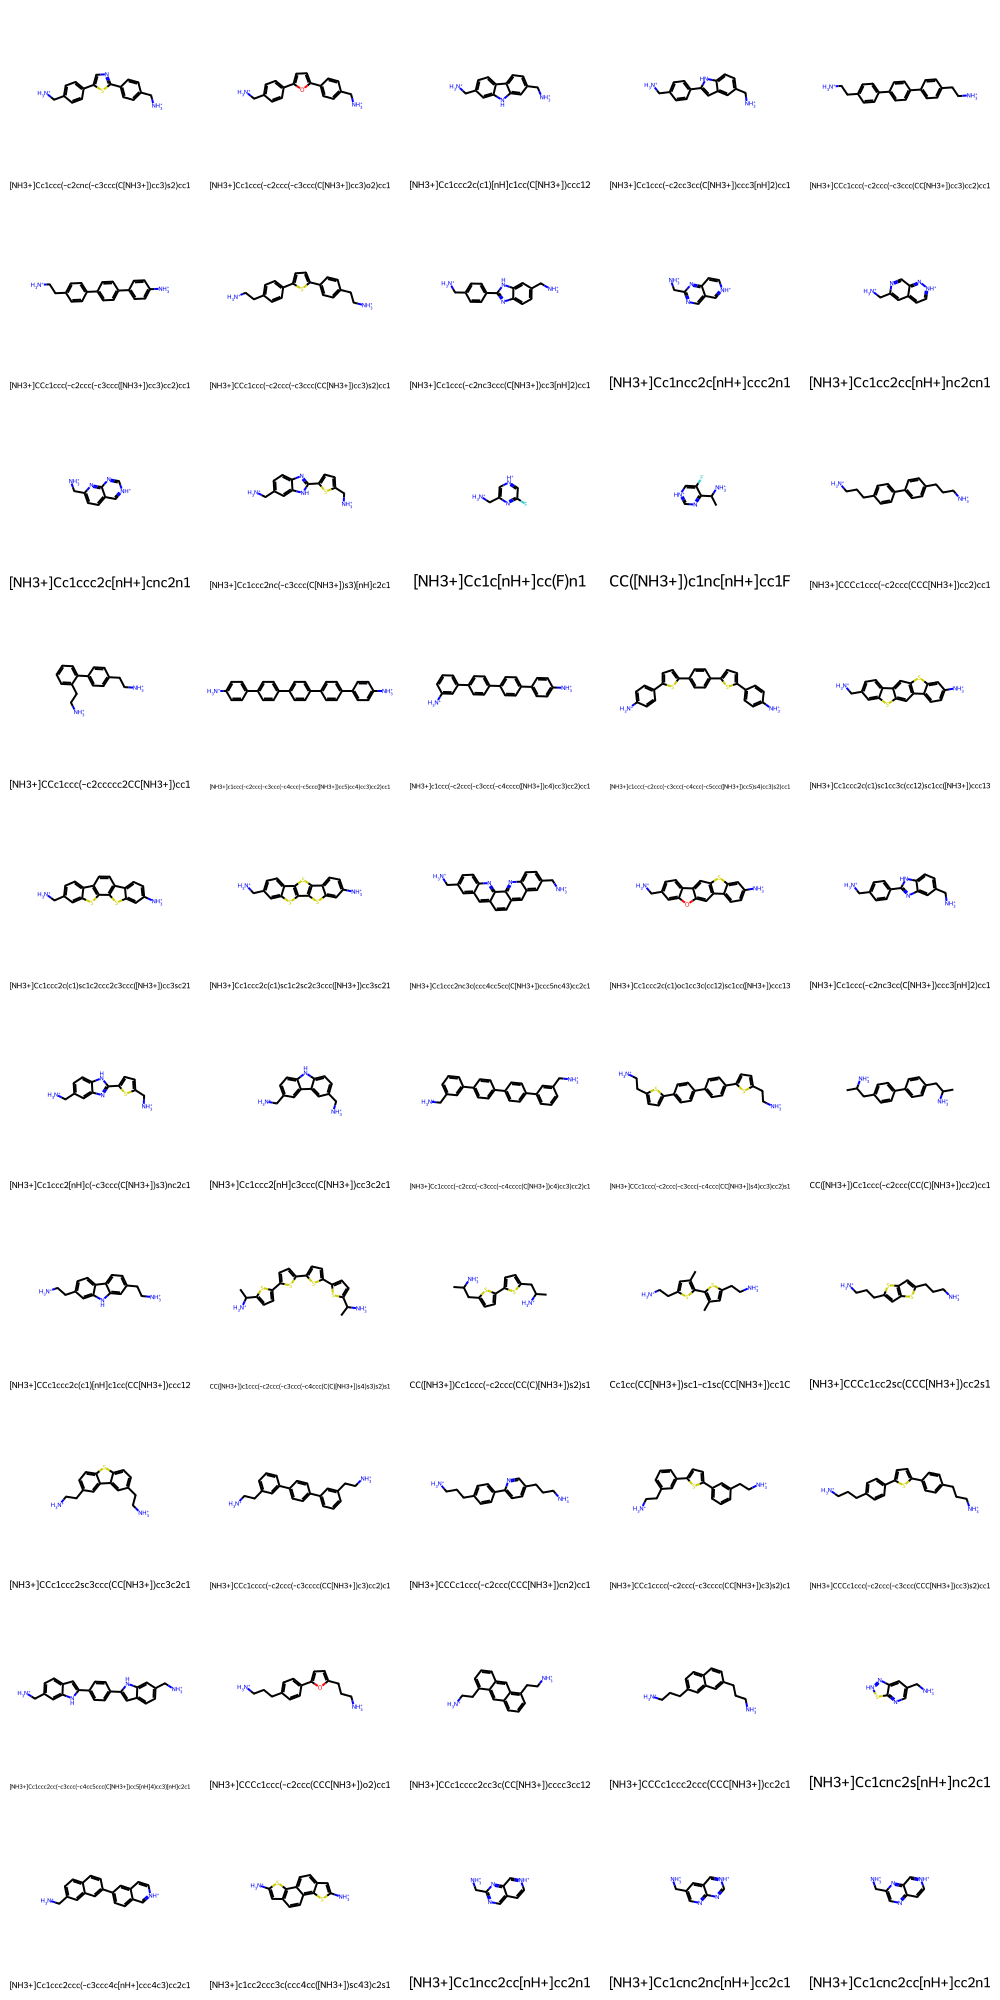

In [16]:
from utils import visualize_smiles_list
visualize_smiles_list(smiles_list[:50])

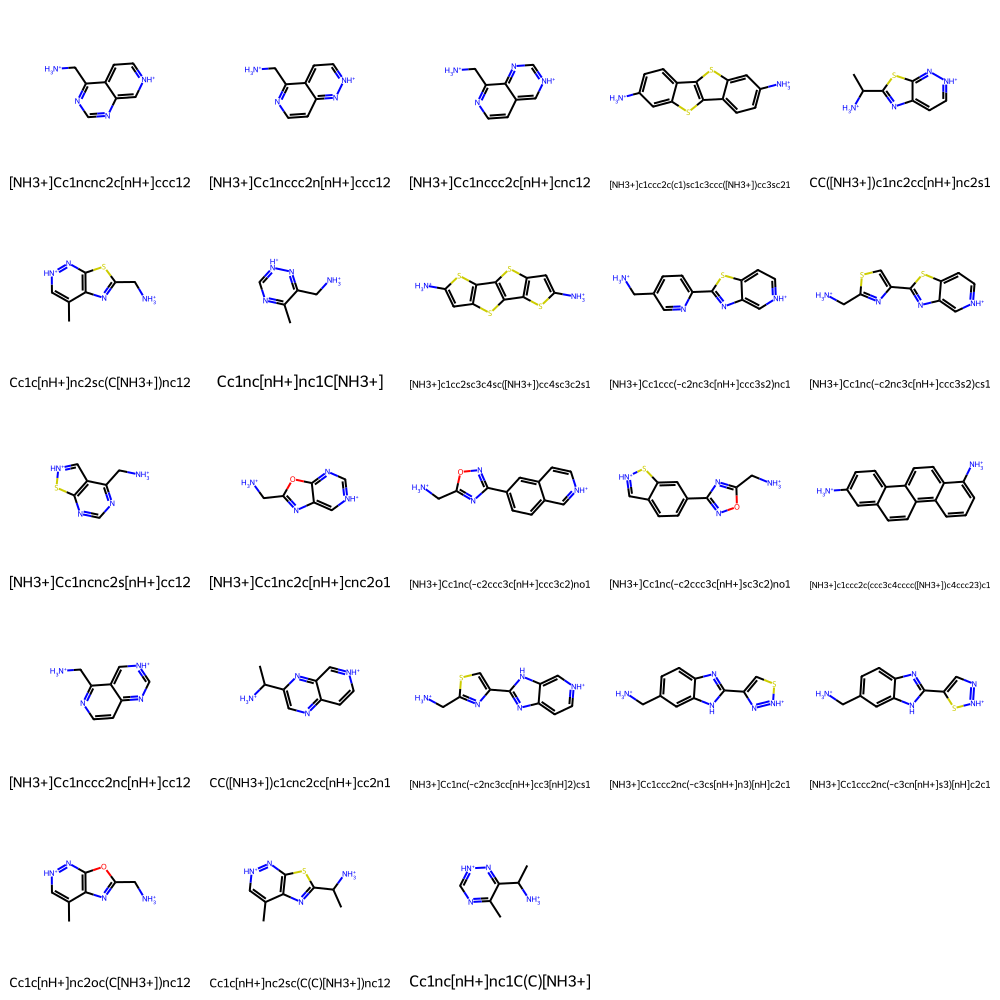

In [17]:
visualize_smiles_list(smiles_list[50:])

### Fingerprint criteria

In [2]:
hse_frontier_dataframe = pd.read_csv(
    PROJECT_ROOT_DIRECTORY + '02-metadata/06-csv-files/08-hse-frontier.csv', index_col='identifier'
)
organic_genome_dataframe = pd.read_csv(
    PROJECT_ROOT_DIRECTORY + '02-metadata/06-csv-files/01-organic-genome.csv', index_col='identifier'
)
fingerprint_dataframe = pd.read_csv(
    PROJECT_ROOT_DIRECTORY + '02-metadata/06-csv-files/02-organic-fingerprints.csv', index_col='identifier'
)

In [3]:
# combine the three dataframes
combined_dataframe = pd.merge(organic_genome_dataframe, fingerprint_dataframe, left_index=True, right_index=True)
combined_dataframe = pd.merge(combined_dataframe, hse_frontier_dataframe, left_index=True, right_index=True)
combined_dataframe

,smiles_canonical,generation,ringcount,linkage_p,six_ring_p,primaryamine,linker_length,linker_position,hetero_nitrogen,fluorination,...,pyrrole,sidechain_on_linker,sidechain_on_backbone,inorganic_cbm_gamma,inorganic_cbm_z,inorganic_vbm_gamma,inorganic_vbm_z,organic_LUMO,organic_HOMO,alignment_type
identifier,,,,,,,,,,,,,,,,,,,,,
1,[NH3+]Cc1cc2sc(C[NH3+])cc2s1,2.0,2,0.0,0.0,2,2,1.0,0,0,...,0,0,0,2.618151,2.618151,-0.066349,-0.066349,3.901251,-0.772949,Ia
4,[NH3+]Cc1ccc(C[NH3+])s1,1.0,1,0.0,0.0,2,2,1.0,0,0,...,0,0,0,2.583026,2.583026,0.006826,0.006826,4.142126,-1.545974,Ia
5,[NH3+]Cc1ccc(C[NH3+])o1,2.0,1,0.0,0.0,2,2,1.0,0,0,...,0,0,0,2.419301,2.419301,0.184801,0.184801,4.525701,-1.222399,Ia
6,[NH3+]Cc1ccc(C[NH3+])[nH]1,2.0,1,0.0,0.0,2,2,1.0,0,0,...,1,0,0,2.296376,2.296376,0.046376,0.046376,4.524576,-0.671524,Ia
7,Cc1cc(C[NH3+])ccc1C[NH3+],1.0,1,0.0,1.0,2,2,1.0,0,0,...,0,0,1,2.588476,2.588476,-0.046924,-0.046924,4.209476,-1.704724,Ia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34296,CC([NH3+])c1cn[nH+]cn1,4.0,1,0.0,1.0,1,1,1.0,2,0,...,0,1,0,2.671026,2.623126,-0.211774,-0.053574,1.813926,-4.157974,IIb
34299,[NH3+]Cc1nn[nH+]cc1F,4.0,1,0.0,1.0,1,1,1.0,2,1,...,0,0,0,2.589251,2.596551,-0.182949,0.190351,1.707651,-4.296349,IIb
34300,[NH3+]Cc1cc(F)[nH+]nn1,4.0,1,0.0,1.0,1,1,1.0,2,1,...,0,0,0,2.500526,2.441726,-0.115174,0.218726,1.490026,-4.347574,IIb


In [6]:
# merge the forward design dataframe with the combined dataframe
combined_dataframe_2 = pd.merge(
    combined_dataframe, forward_design_dataframe[['smiles_canonical','synthesizability_decision']], on='smiles_canonical', how='left',
)

In [7]:
combined_dataframe_2

,smiles_canonical,generation,ringcount,linkage_p,six_ring_p,primaryamine,linker_length,linker_position,hetero_nitrogen,fluorination,...,sidechain_on_linker,sidechain_on_backbone,inorganic_cbm_gamma,inorganic_cbm_z,inorganic_vbm_gamma,inorganic_vbm_z,organic_LUMO,organic_HOMO,alignment_type,synthesizability_decision
0,[NH3+]Cc1cc2sc(C[NH3+])cc2s1,2.0,2,0.0,0.0,2,2,1.0,0,0,...,0,0,2.618151,2.618151,-0.066349,-0.066349,3.901251,-0.772949,Ia,False
1,[NH3+]Cc1ccc(C[NH3+])s1,1.0,1,0.0,0.0,2,2,1.0,0,0,...,0,0,2.583026,2.583026,0.006826,0.006826,4.142126,-1.545974,Ia,True
2,[NH3+]Cc1ccc(C[NH3+])o1,2.0,1,0.0,0.0,2,2,1.0,0,0,...,0,0,2.419301,2.419301,0.184801,0.184801,4.525701,-1.222399,Ia,True
3,[NH3+]Cc1ccc(C[NH3+])[nH]1,2.0,1,0.0,0.0,2,2,1.0,0,0,...,0,0,2.296376,2.296376,0.046376,0.046376,4.524576,-0.671524,Ia,True
4,Cc1cc(C[NH3+])ccc1C[NH3+],1.0,1,0.0,1.0,2,2,1.0,0,0,...,0,1,2.588476,2.588476,-0.046924,-0.046924,4.209476,-1.704724,Ia,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,CC([NH3+])c1cn[nH+]cn1,4.0,1,0.0,1.0,1,1,1.0,2,0,...,1,0,2.671026,2.623126,-0.211774,-0.053574,1.813926,-4.157974,IIb,True
364,[NH3+]Cc1nn[nH+]cc1F,4.0,1,0.0,1.0,1,1,1.0,2,1,...,0,0,2.589251,2.596551,-0.182949,0.190351,1.707651,-4.296349,IIb,False
365,[NH3+]Cc1cc(F)[nH+]nn1,4.0,1,0.0,1.0,1,1,1.0,2,1,...,0,0,2.500526,2.441726,-0.115174,0.218726,1.490026,-4.347574,IIb,False
366,CC([NH3+])c1cc[nH+]nn1,4.0,1,0.0,1.0,1,1,1.0,2,0,...,1,0,2.646776,2.595976,-0.149524,-0.013324,2.043376,-3.812524,IIb,True


In [27]:
# manually add row to combined_dataframe_2
new_row_1 = {
    'generation': 6,
    'ringcount': 5,
    'linkage_p': 0,
    'six_ring_p': 1,
    'primaryamine': 2,
    'linker_length': 0,
    'linker_position': 1,
    'hetero_nitrogen':0,
    'fluorination': 0,
    'furan': 0,
    'pyrrole': 0,
    'sidechain_on_linker': 0,
    'sidechain_on_backbone': 0,
    'alignment_type': 'Ib',
    'synthesizability_decision': True
}

new_row_2 = {
    'generation': 5,
    'ringcount': 5,
    'linkage_p': 0,
    'six_ring_p': 1,
    'primaryamine': 2,
    'linker_length': 2,
    'linker_position': 10/11,
    'hetero_nitrogen':0,
    'fluorination': 0,
    'furan': 0,
    'pyrrole': 0,
    'sidechain_on_linker': 0,
    'sidechain_on_backbone': 0,
    'alignment_type': 'Ib',
    'synthesizability_decision': True
}

new_row_3 = {
    'generation': 6,
    'ringcount': 6,
    'linkage_p': 0,
    'six_ring_p': 1,
    'primaryamine': 2,
    'linker_length': 2,
    'linker_position': 12/13,
    'hetero_nitrogen':0,
    'fluorination': 0,
    'furan': 0,
    'pyrrole': 0,
    'sidechain_on_linker': 0,
    'sidechain_on_backbone': 0,
    'alignment_type': 'Ib',
    'synthesizability_decision': True
}

new_row_4 = {
    'generation': 5,
    'ringcount': 6,
    'linkage_p': 0,
    'six_ring_p': 1,
    'primaryamine': 2,
    'linker_length': 2,
    'linker_position': 1,
    'hetero_nitrogen':0,
    'fluorination': 0,
    'furan': 0,
    'pyrrole': 0,
    'sidechain_on_linker': 0,
    'sidechain_on_backbone': 0,
    'alignment_type': 'Ib',
    'synthesizability_decision': True
}

new_row_df = pd.DataFrame([new_row_1, new_row_2, new_row_3, new_row_4])
combined_dataframe_3 = pd.concat([combined_dataframe_2, new_row_df], ignore_index=True)

In [28]:
# sort dataframe_melt by alignment_type, by "Ia", "Ib", "IIa", "IIb"
combined_dataframe_3['alignment_type'] = pd.Categorical(
    combined_dataframe_3['alignment_type'], 
    categories=['Ia', 'Ib', 'IIa', 'IIb'], 
    ordered=True
)
dataframe_melt = combined_dataframe_3.sort_values(by=['alignment_type'])

dataframe_melt = pd.melt(combined_dataframe_3, id_vars=['alignment_type', 'synthesizability_decision','generation'], value_vars=COLUMNS_DICT['molecular_fingerprint'])

In [29]:
# sort dataframe_melt by alignment_type, by "Ia", "Ib", "IIa", "IIb"
dataframe_melt['alignment_type'] = pd.Categorical(
    dataframe_melt['alignment_type'], 
    categories=['Ia', 'Ib', 'IIa', 'IIb'], 
    ordered=True
)
dataframe_melt = dataframe_melt.sort_values(by=['alignment_type'])

/var/folders/tn/23sfm0zs5f725m1tjsjgv1tc0000gn/T/ipykernel_24942/875727768.py:20: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/var/folders/tn/23sfm0zs5f725m1tjsjgv1tc0000gn/T/ipykernel_24942/875727768.py:23: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



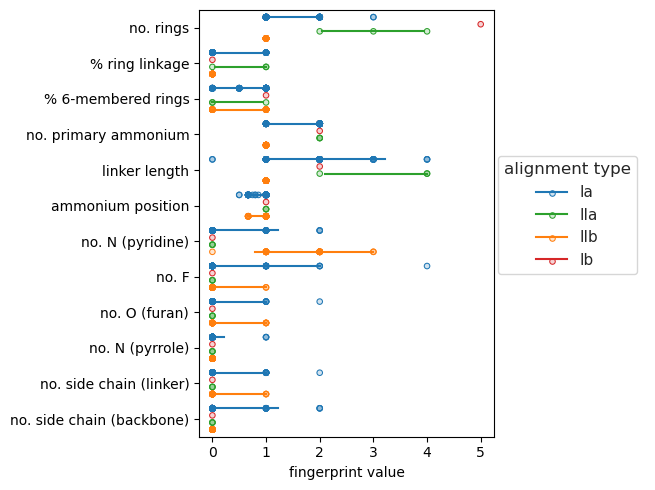

In [ ]:
import seaborn.objects as so
from seaborn import axes_style
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))
(
    so.Plot(data=dataframe_melt.query('synthesizability_decision==True or alignment_type == "Ib" and generation <=6'), 
            x='value', y='variable',
            color='alignment_type')
    .add(so.Dots(), so.Dodge())
    #.add(so.Range(), so.Est(errorbar="sd"), so.Dodge())
    .add(so.Range(), so.Est(errorbar=("pi", 95)), so.Dodge())

    .scale(color=['tab:blue', 'tab:green', 'tab:orange', 'tab:red'])
    .label(x="fingerprint value", y="", color="alignment type")
    .theme(axes_style("ticks"))
    .on(ax)
    .plot()
    )
fig.tight_layout()
fig.show()

#ax.set_yticks(np.arange(0, -12, -1))
ax.set_yticklabels(['no. rings', '% ring linkage', '% 6-membered rings','no. primary ammonium', 'linker length', 'ammonium position', 'no. N (pyridine)', 'no. F', 'no. O (furan)', 'no. N (pyrrole)', 'no. side chain (linker)', 'no. side chain (backbone)'])
#ax.axvline(x=0, linestyle='--', alpha=0.5, color='black')
fig#.savefig('../rawfigures/fingerprint-criteria.svg')


/var/folders/tn/23sfm0zs5f725m1tjsjgv1tc0000gn/T/ipykernel_4929/3892137178.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


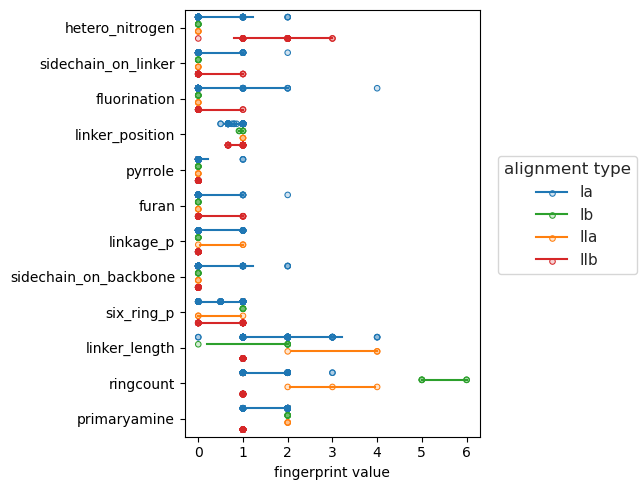

In [30]:
import seaborn.objects as so
from seaborn import axes_style
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5, 5))
(
    so.Plot(data=dataframe_melt.query('synthesizability_decision==True or alignment_type == "Ib" and generation <=6'), 
            x='value', y='variable',
            color='alignment_type')
    .add(so.Dots(), so.Dodge())
    #.add(so.Range(), so.Est(errorbar="sd"), so.Dodge())
    .add(so.Range(), so.Est(errorbar=("pi", 95)), so.Dodge())

    .scale(color=['tab:blue', 'tab:green', 'tab:orange', 'tab:red'])
    .label(x="fingerprint value", y="", color="alignment type")
    .theme(axes_style("ticks"))
    .on(ax)
    .plot()
    )
fig.tight_layout()
fig.show()

#ax.set_yticks(np.arange(0, -12, -1))
#ax.set_yticklabels(['no. rings', '% ring linkage', '% 6-membered rings','no. primary ammonium', 'linker length', 'ammonium position', 'no. N (pyridine)', 'no. F', 'no. O (furan)', 'no. N (pyrrole)', 'no. side chain (linker)', 'no. side chain (backbone)'])
#ax.axvline(x=0, linestyle='--', alpha=0.5, color='black')
#fig.savefig('../rawfigures/fingerprint-criteria.svg')